<a href="https://colab.research.google.com/github/ericodle/PhyloGreg/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install biopython
!pip install dendropy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 36.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.6/458.6 kB 9.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

from Bio import SeqIO

import matplotlib.pyplot as plt

import pickle

import numpy as np

from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram

import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import dendropy

In [ ]:
tensor_sequences = torch.load('/content/drive/MyDrive/tensor_sequences.pt')
tensor_labels = torch.load('/content/drive/MyDrive/tensor_labels.pt')

In [ ]:
# Split the data into training and validation sets
train_data = TensorDataset(tensor_sequences, tensor_labels)
train_loader = DataLoader(train_data, batch_size=10000, shuffle=True)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh((2 / np.pi) ** 0.5 * (x + 0.044715 * torch.pow(x, 3))))

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.gelu = GELU()

    def forward(self, x):
        out = self.gelu(self.fc1(x))
        out = self.fc2(out)
        return out

# Define the input size, hidden size, and output size
input_size = 2048

In [ ]:
# Instantiate the model
model = MLP(input_size)

# Specify the CUDA device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to CUDA
model.to(device)

# Print the model architecture
print(model)

MLP(
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (gelu): GELU()
)


In [ ]:
# Define the loss function and optimizer
loss_function = nn.MSELoss()  # Adjust based on your task
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Adjust learning rate as needed
# Training loop
num_epochs = 400

In [ ]:
train_loss_by_epoch = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    total_samples = 0
    correct_samples = 0
    
    for inputs, labels in train_loader:
        # Move inputs and labels to CUDA
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update training loss and accuracy
        train_loss += loss.item() * inputs.size(0)
        _, predicted_labels = torch.max(outputs, dim=1)
        total_samples += labels.size(0)

    # Calculate average training loss and accuracy
    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_samples / total_samples

    train_loss_by_epoch.append(train_loss)

    # Print the training loss and validation accuracy for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10000, 1])) that is different to the input size (torch.Size([10000, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8377, 1])) that is different to the input size (torch.Size([8377, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/400, Train Loss: 29675093182.8445
Epoch 2/400, Train Loss: 29667992378.6761
Epoch 3/400, Train Loss: 29651703283.7086
Epoch 4/400, Train Loss: 29624455245.7874
Epoch 5/400, Train Loss: 29585638736.9199
Epoch 6/400, Train Loss: 29535144700.9636
Epoch 7/400, Train Loss: 29473060731.7140
Epoch 8/400, Train Loss: 29399537429.3267
Epoch 9/400, Train Loss: 29314807316.9226
Epoch 10/400, Train Loss: 29219113286.2021
Epoch 11/400, Train Loss: 29112736351.6797
Epoch 12/400, Train Loss: 28995901159.9501
Epoch 13/400, Train Loss: 28868960590.4592
Epoch 14/400, Train Loss: 28732190258.6772
Epoch 15/400, Train Loss: 28585834786.0916
Epoch 16/400, Train Loss: 28430311712.3963
Epoch 17/400, Train Loss: 28265860072.2066
Epoch 18/400, Train Loss: 28092762378.3566
Epoch 19/400, Train Loss: 27911413399.4652
Epoch 20/400, Train Loss: 27722161133.1074
Epoch 21/400, Train Loss: 27525223230.1629
Epoch 22/400, Train Loss: 27321016779.4971
Epoch 23/400, Train Loss: 27109839213.5454
Epoch 24/400, Train 

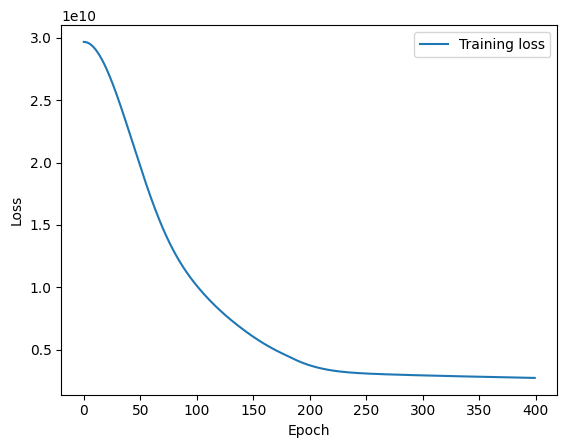

In [ ]:
plt.plot(train_loss_by_epoch, label='Training loss')
#plt.plot(val_accuracies, label='Validation accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/mlp_model_state_dict.pth')

# Load it and analyze it

In [ ]:
class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh((2 / np.pi) ** 0.5 * (x + 0.044715 * torch.pow(x, 3))))

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.gelu = GELU()

    def forward(self, x):
        out = self.gelu(self.fc1(x))
        out = self.fc2(out)
        return out

In [ ]:
# Define the input size
input_size = 2048

# Create an instance of the MLP model
model = MLP(input_size)

# Load the pre-trained model's state dictionary
model.load_state_dict(torch.load('/content/drive/MyDrive/mlp_model_state_dict.pth', map_location=torch.device('cpu')))

model

MLP(
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (gelu): GELU()
)

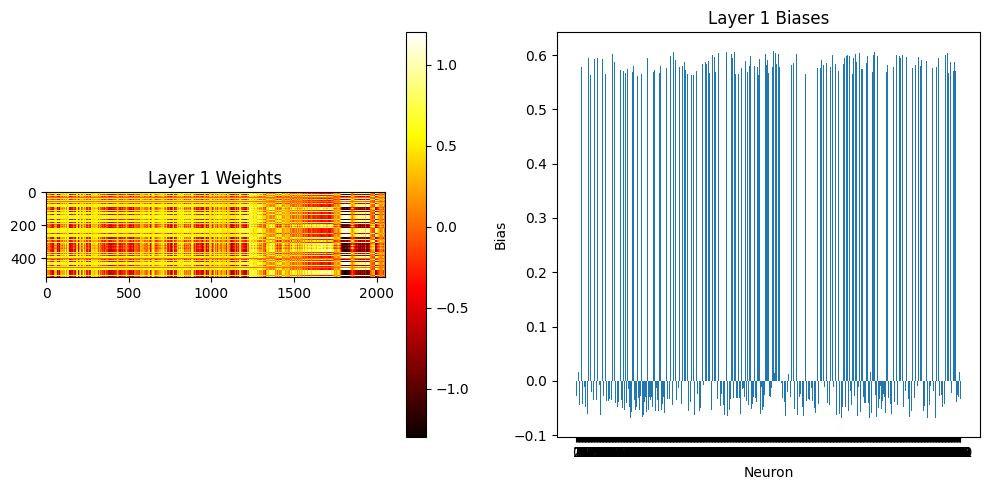

In [ ]:
# Access the weights and biases of each layer
weights_fc1 = model.fc1.weight.data.numpy()
biases_fc1 = model.fc1.bias.data.numpy()

weights_fc2 = model.fc2.weight.data.numpy()
biases_fc2 = model.fc2.bias.data.numpy()

# Plotting the weights and biases
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Layer 1 Weights")
plt.imshow(weights_fc1, cmap='hot', interpolation='nearest')
plt.colorbar()

plt.subplot(122)
plt.title("Layer 1 Biases")
plt.bar(range(len(biases_fc1)), biases_fc1)
plt.xticks(range(len(biases_fc1)))
plt.xlabel("Neuron")
plt.ylabel("Bias")

plt.tight_layout()
plt.show()

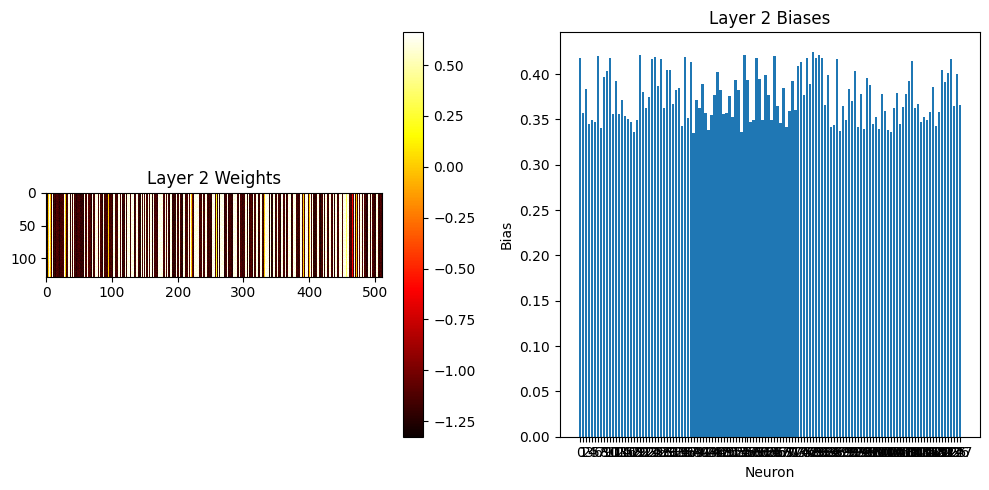

In [ ]:
# Plotting the weights and biases
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Layer 2 Weights")
plt.imshow(weights_fc2, cmap='hot', interpolation='nearest')
plt.colorbar()

plt.subplot(122)
plt.title("Layer 2 Biases")
plt.bar(range(len(biases_fc2)), biases_fc2)
plt.xticks(range(len(biases_fc2)))
plt.xlabel("Neuron")
plt.ylabel("Bias")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


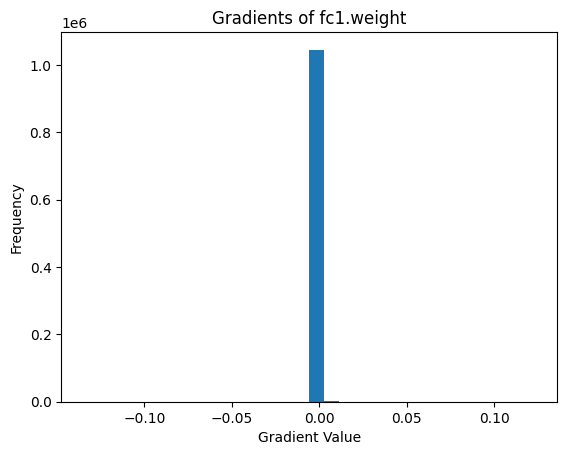

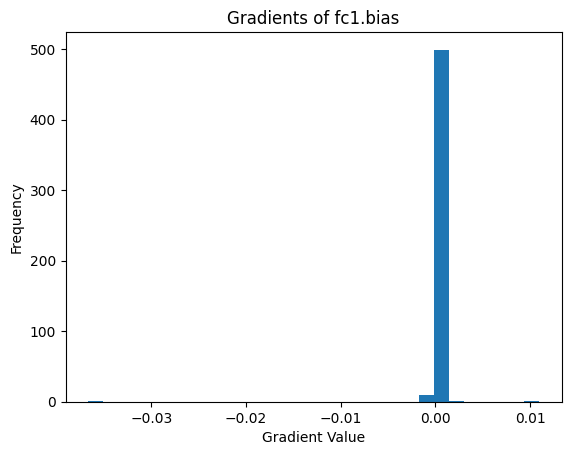

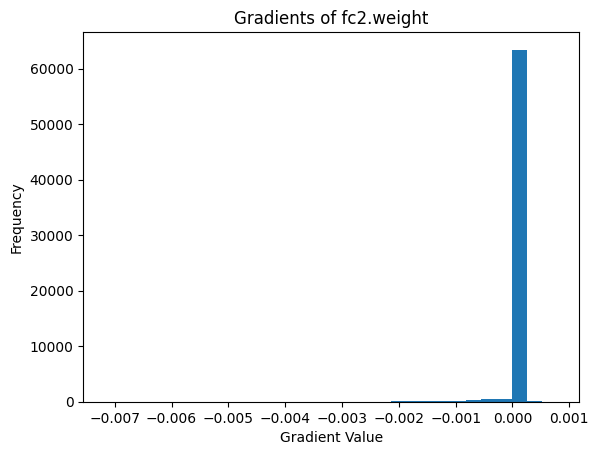

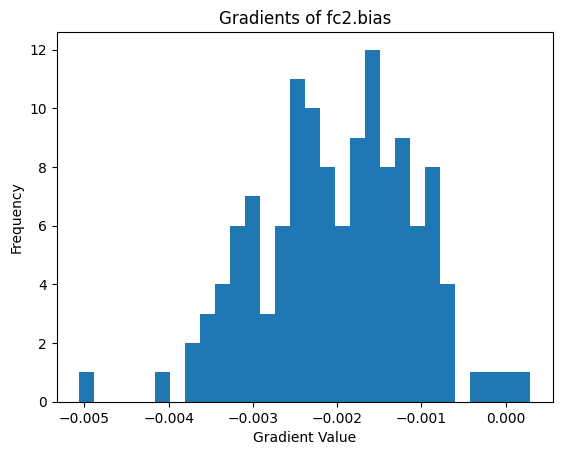

In [ ]:
# Prepare the input tensor
input_tensor = torch.randn(1, input_size)

# Create a target value tensor (example)
target_tensor = torch.tensor([[0.5]])

# Compute the output tensor
output_tensor = model(input_tensor)

# Compute the loss between the output and target
loss = nn.MSELoss()(output_tensor, target_tensor)

# Perform backpropagation to compute gradients
loss.backward()

# Visualize the gradients at each level
for name, param in model.named_parameters():
    if param.grad is not None:
        plt.figure()
        plt.title(f"Gradients of {name}")
        plt.hist(param.grad.detach().numpy().flatten(), bins=30)
        plt.xlabel("Gradient Value")
        plt.ylabel("Frequency")
        plt.show()

## ANALYZE TRAINED MODEL

In [ ]:
greg_sequences = torch.load("/content/drive/MyDrive/gregssu_preprocessed_sequences.pt")

In [ ]:
# Convert the preprocessed sequences to a PyTorch tensor
input_data = torch.tensor(greg_sequences, dtype=torch.float32)

# Set the model to evaluation mode
model.eval()

# Get the outputs from the FC5 layer
mlp_outputs = model(input_data)

# Convert the outputs to a list
mlp_outputs_list = mlp_outputs.tolist()

<ipython-input-18-b25b82e80968>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(greg_sequences, dtype=torch.float32)


In [ ]:
# Load the sequence names from the file
with open("/content/drive/MyDrive/sequence_labels.pkl", "rb") as file:
    sequence_names = pickle.load(file)

In [ ]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist

# Convert vectors to a numpy array
mlp_outputs_array = np.array(mlp_outputs_list)

In [ ]:
print(mlp_outputs_array.shape)

(124, 128)


In [ ]:
mlp_outputs_array

array([[144273.5625   , 144272.046875 , 144271.703125 , ...,
        144264.84375  , 144274.03125  , 144269.515625 ],
       [143914.0625   , 143912.515625 , 143912.28125  , ...,
        143905.375    , 143914.625    , 143910.109375 ],
       [146446.65625  , 146445.03125  , 146444.46875  , ...,
        146437.71875  , 146447.4375   , 146442.78125  ],
       ...,
       [131686.25     , 131685.28125  , 131684.078125 , ...,
        131679.671875 , 131690.125    , 131686.09375  ],
       [129992.953125 , 129990.359375 , 129990.828125 , ...,
        129984.5703125, 129992.625    , 129988.78125  ],
       [124849.       , 124846.578125 , 124846.546875 , ...,
        124840.7109375, 124847.609375 , 124844.875    ]])

In [ ]:
# Compute distance matrix
mlp_distances = pdist(mlp_outputs_array, metric='euclidean')

In [ ]:
print(mlp_distances.shape)

(7626,)


In [ ]:
mlp_distances

array([ 4066.61537977, 24588.24925648, 33341.15823509, ...,
       19189.65808002, 77387.91921159, 58198.27063457])

In [ ]:
from scipy.spatial.distance import pdist, squareform

In [ ]:
#Convert the distance array to a squareform distance matrix
mlp_distance_matrix = squareform(mlp_distances)

In [ ]:
print(mlp_distance_matrix.shape)

(124, 124)


In [ ]:
mlp_distance_matrix

array([[     0.        ,   4066.61537977,  24588.24925648, ...,
        142379.59023415, 161569.23237507, 219767.50277188],
       [  4066.61537977,      0.        ,  28654.86445688, ...,
        138312.97490524, 157502.61706883, 215700.88748078],
       [ 24588.24925648,  28654.86445688,      0.        , ...,
        166967.83850778, 186157.48136323, 244355.75180805],
       ...,
       [142379.59023415, 138312.97490524, 166967.83850778, ...,
             0.        ,  19189.65808002,  77387.91921159],
       [161569.23237507, 157502.61706883, 186157.48136323, ...,
         19189.65808002,      0.        ,  58198.27063457],
       [219767.50277188, 215700.88748078, 244355.75180805, ...,
         77387.91921159,  58198.27063457,      0.        ]])

In [ ]:
# Create a DataFrame from the condensed matrix
mlp_pd = pd.DataFrame(mlp_distance_matrix, index=sequence_names, columns=sequence_names)

#pad
mlp_pd = mlp_pd.fillna(0)

In [ ]:
print(mlp_pd.shape)

(124, 124)


In [ ]:
mlp_pd

,Y162320,MK541781,MG022774,EF492504,OP968025,MF423346,KU900227,AF022198,AY999082,AF022194,...,MT112170,MG009200,HQ891113,HQ891115,HQ876007,FJ976721,MG009199,LC034108,HQ876006,KU726617
Y162320,0.000000,4066.615380,24588.249256,33341.158235,10377.087888,19194.470481,37748.043687,50671.714148,11741.330358,15021.502978,...,162513.115649,179540.412143,116816.511355,164413.948739,173163.002867,193540.093913,299498.208370,142379.590234,161569.232375,219767.502772
MK541781,4066.615380,0.000000,28654.864457,37407.773430,14443.703031,23261.085671,41814.658912,54738.329410,7674.716763,19088.117804,...,158446.500312,175473.796812,112749.896018,160347.333411,169096.387568,189473.478614,295431.593046,138312.974905,157502.617069,215700.887481
MG022774,24588.249256,28654.864457,0.000000,8752.909026,14211.161599,5393.779157,13159.794607,26083.465262,36329.575694,9566.747917,...,187101.364316,204128.660598,141404.759657,189002.197575,197751.251901,218128.342909,324086.457116,166967.838508,186157.481363,244355.751808
EF492504,33341.158235,37407.773430,8752.909026,0.000000,22964.070505,14146.687880,4406.885902,17330.556645,45082.484279,18319.656411,...,195854.273105,212881.569306,150157.668337,197755.106423,206504.160828,226881.251818,332839.365920,175720.747165,194910.390272,253108.660731
OP968025,10377.087888,14443.703031,14211.161599,22964.070505,0.000000,8817.382684,27370.955932,40294.626475,22118.415371,4644.416690,...,172890.203048,189917.499443,127193.598536,174791.036240,183540.090495,203917.181533,309875.295847,152756.677424,171946.319978,230144.590416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FJ976721,193540.093913,189473.478614,218128.342909,226881.251818,203917.181533,212734.564173,231288.137399,244211.807935,181798.768233,208561.595589,...,31026.982718,13999.703379,76723.586698,29126.146881,20377.091721,0.000000,105958.115728,51160.511155,31970.861721,26227.409212
MG009199,299498.208370,295431.593046,324086.457116,332839.365920,309875.295847,318692.678422,337246.251548,350169.922216,287756.881950,314519.709603,...,136985.092993,119957.797209,182681.698074,135084.259844,126335.207069,105958.115728,0.000000,157118.619517,137928.976790,79730.708457
LC034108,142379.590234,138312.974905,166967.838508,175720.747165,152756.677424,161574.059870,180127.632807,193051.303545,130638.263162,157401.090863,...,20133.529166,37160.822416,25563.079233,22034.365964,30783.426039,51160.511155,157118.619517,0.000000,19189.658080,77387.919212
HQ876006,161569.232375,157502.617069,186157.481363,194910.390272,171946.319978,180763.702616,199317.275841,212240.946375,149827.906731,176590.734044,...,943.990236,17971.193245,44752.726582,2844.727921,11593.771220,31970.861721,137928.976790,19189.658080,0.000000,58198.270635


In [ ]:
# Sort the DataFrame by row and column values
mlp_pd_sorted = mlp_pd.sort_values(by=sequence_names, axis=0).sort_values(by=sequence_names, axis=1)

In [ ]:
print(mlp_pd_sorted.shape)

(124, 124)


In [ ]:
mlp_pd_sorted

,Y162320,KC110869,JF906999,AF080611,FJ459750,MK541781,AY179976,DQ096835,FJ459743,MN381955,...,MG009200,FJ976721,KU726617,FJ832162,KC890799,MT112171,MG009199,KY678215,AY196709,OK316957
Y162320,0.000000,84.412615,453.463954,2735.038122,3821.738295,4066.615380,4120.683231,4492.332757,5677.044211,5843.806528,...,179540.412143,193540.093913,219767.502772,237653.662874,259699.659429,273226.618036,299498.208370,312992.580978,403787.809946,745194.842199
KC110869,84.412615,0.000000,373.037298,2815.334273,3902.042056,3986.400192,4200.943534,4412.092979,5596.688806,5924.044827,...,179460.114000,193459.798992,219687.208043,237573.365172,259619.362228,273146.320533,299417.911141,312912.286732,403707.513135,745114.547007
JF906999,453.463954,373.037298,0.000000,3188.166652,4274.892289,3613.489562,4573.802592,4039.190909,5223.835336,6296.920020,...,179087.249190,193086.933023,219314.342044,237200.500286,259246.496926,272773.455606,299045.046139,312539.420767,403334.647814,744741.681385
AF080611,2735.038122,2815.334273,3188.166652,0.000000,1086.770160,6801.630771,1385.658605,7227.341173,8411.998281,3108.779497,...,182275.412818,196275.096291,222502.505285,240388.663872,262434.660299,275961.619171,302233.209669,315727.583901,406522.811165,747929.844689
FJ459750,3821.738295,3902.042056,4274.892289,1086.770160,0.000000,7888.338897,299.184982,8314.051653,9498.710294,2022.101076,...,183362.123177,197361.806349,223589.215316,241475.374214,263521.371215,277048.329490,303319.919939,316814.293572,407609.521972,749016.554769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT112171,273226.618036,273146.320533,272773.455606,275961.619171,277048.329490,269160.002711,277347.255750,268734.286957,267549.632505,279070.364521,...,93686.206578,79686.526408,53459.120694,35572.955474,13526.977462,0.000000,26271.590865,39765.984449,130561.195048,471968.227282
MG009199,299498.208370,299417.911141,299045.046139,302233.209669,303319.919939,295431.593046,303618.846307,295005.877332,293821.223117,305341.955131,...,119957.797209,105958.115728,79730.708457,61844.546119,39798.556061,26271.590865,0.000000,13494.427980,104289.605396,445696.636613
KY678215,312992.580978,312912.286732,312539.420767,315727.583901,316814.293572,308925.965702,317113.221156,308500.250371,307315.598749,318836.330688,...,133452.176300,119452.488161,93225.079199,75338.930126,53292.942467,39765.984449,13494.427980,0.000000,90795.241997,432202.261754
AY196709,403787.809946,403707.513135,403334.647814,406522.811165,407609.521972,399721.194646,407908.448212,399295.479039,398110.825138,409631.557151,...,224247.400164,210247.717687,184020.309700,166134.149601,144088.150982,130561.195048,104289.605396,90795.241997,0.000000,341407.037618


In [ ]:
# Normalize the values
scaler = MinMaxScaler()
mlp_pd_norm = pd.DataFrame(scaler.fit_transform(mlp_pd_sorted), index=mlp_pd_sorted.index, columns=mlp_pd_sorted.columns)

In [ ]:
print(mlp_pd_norm.shape)

(124, 124)


In [ ]:
mlp_pd_norm

,Y162320,KC110869,JF906999,AF080611,FJ459750,MK541781,AY179976,DQ096835,FJ459743,MN381955,...,MG009200,FJ976721,KU726617,FJ832162,KC890799,MT112171,MG009199,KY678215,AY196709,OK316957
Y162320,0.000000,0.000113,0.000609,0.003657,0.005102,0.005487,0.005499,0.006065,0.007677,0.007781,...,0.317403,0.350836,0.418264,0.468245,0.534917,0.578909,0.671978,0.724181,0.783792,0.869966
KC110869,0.000113,0.000000,0.000501,0.003764,0.005210,0.005379,0.005606,0.005957,0.007568,0.007888,...,0.317261,0.350690,0.418111,0.468087,0.534752,0.578739,0.671798,0.723995,0.783636,0.869872
JF906999,0.000609,0.000501,0.000000,0.004263,0.005707,0.004876,0.006104,0.005453,0.007064,0.008384,...,0.316602,0.350014,0.417402,0.467352,0.533984,0.577949,0.670961,0.723132,0.782912,0.869437
AF080611,0.003670,0.003778,0.004281,0.000000,0.001451,0.009177,0.001849,0.009757,0.011375,0.004139,...,0.322238,0.355793,0.423470,0.473634,0.540550,0.584704,0.678114,0.730509,0.789101,0.873159
FJ459750,0.005129,0.005237,0.005740,0.001453,0.000000,0.010644,0.000399,0.011225,0.012844,0.002692,...,0.324159,0.357763,0.425538,0.475775,0.542789,0.587006,0.680552,0.733023,0.791210,0.874428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT112171,0.366651,0.366583,0.366266,0.368967,0.369883,0.363176,0.370134,0.362810,0.361789,0.371579,...,0.165624,0.144450,0.101744,0.070089,0.027862,0.000000,0.058945,0.092008,0.253432,0.550992
MG009199,0.401906,0.401841,0.401542,0.404093,0.404958,0.398624,0.405195,0.398278,0.397315,0.406560,...,0.212069,0.192073,0.151744,0.121851,0.081975,0.055664,0.000000,0.031222,0.202436,0.520322
KY678215,0.420014,0.419952,0.419662,0.422135,0.422974,0.416832,0.423204,0.416497,0.415562,0.424527,...,0.235925,0.216535,0.177427,0.148439,0.109770,0.084256,0.030277,0.000000,0.176243,0.504568
AY196709,0.541855,0.541806,0.541577,0.543531,0.544193,0.539341,0.544375,0.539077,0.538338,0.545420,...,0.396439,0.381122,0.350230,0.327331,0.296786,0.276631,0.233992,0.210076,0.000000,0.398570


In [ ]:
# Compute linkage matrix
mlp_linkage_matrix = hierarchy.linkage(mlp_pd_norm, method='single')

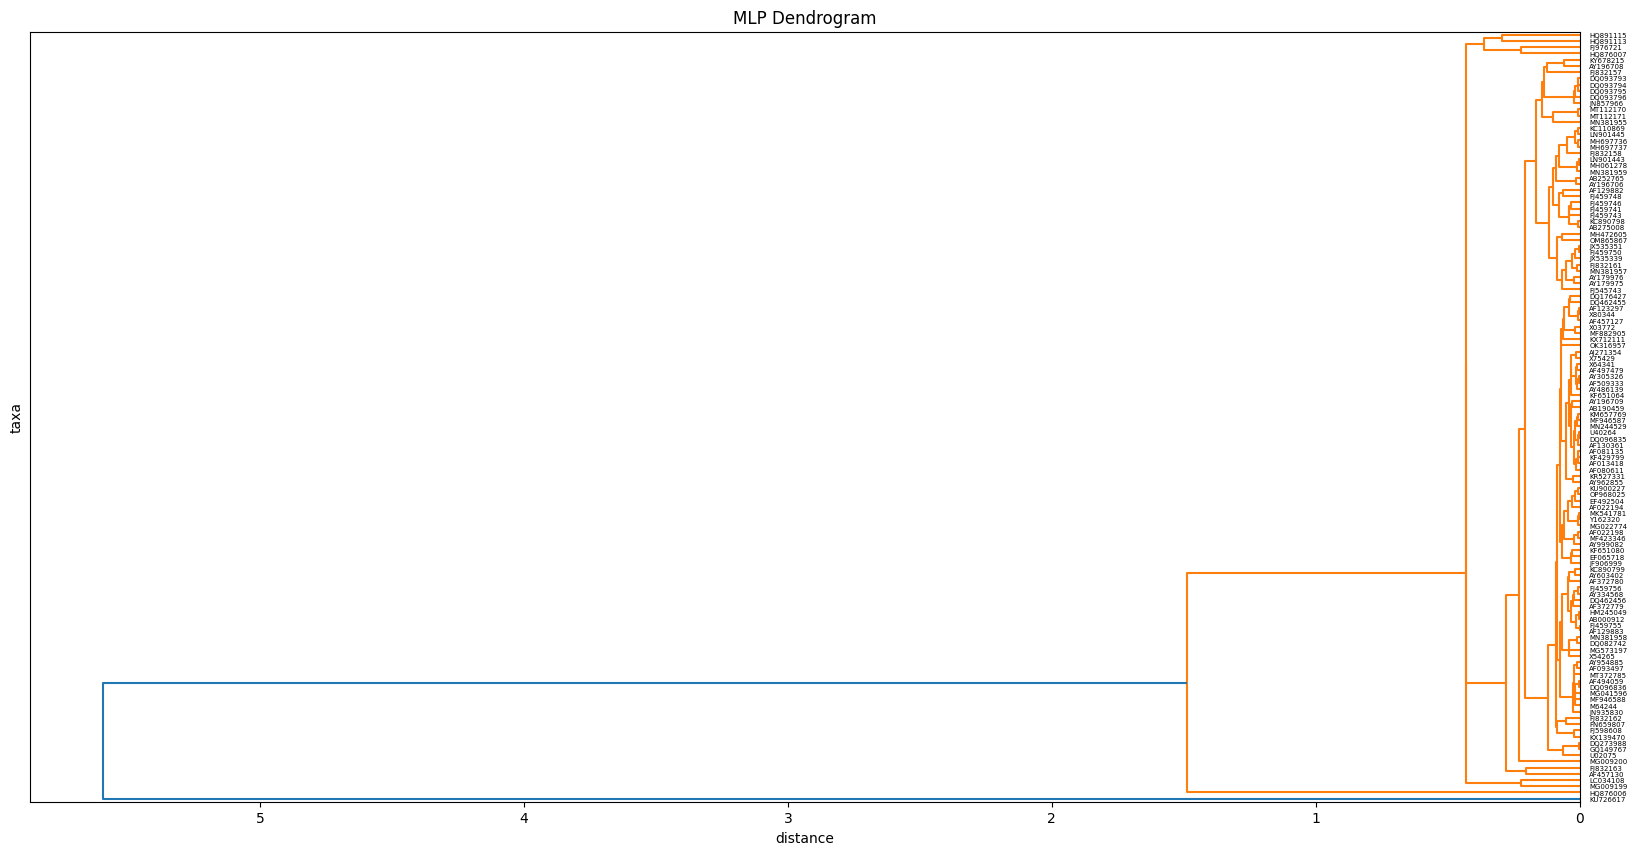

In [ ]:
#Plot the dendrogram
plt.figure(figsize=(20, 10))
mlp_dendrogram = hierarchy.dendrogram(mlp_linkage_matrix, labels=sequence_names, orientation="left")
plt.title('MLP Dendrogram')
plt.xlabel('distance')
plt.ylabel('taxa')

plt.show()

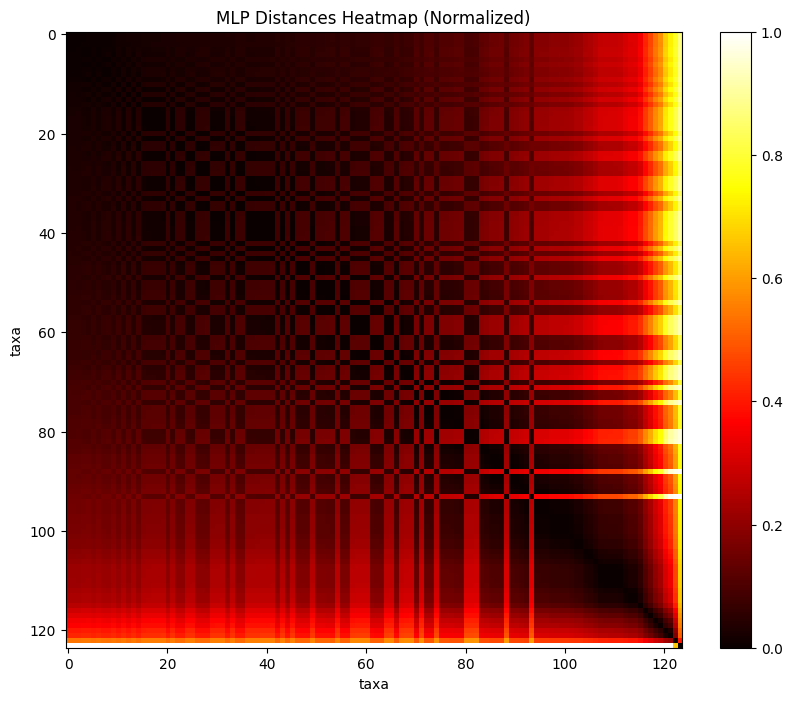

In [ ]:
# Create the heatmap
plt.figure(figsize=(10, 8))
heatmap = plt.imshow(mlp_pd_norm, cmap='hot', interpolation='nearest')
plt.colorbar(heatmap)
plt.title('MLP Distances Heatmap (Normalized)')
plt.xlabel('taxa')
plt.ylabel('taxa')
plt.show()

# ANALYZE GROUND TRUTH TREE





In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import distance
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

# Load the CSV file
greg_pd = pd.read_csv('/content/drive/MyDrive/gregssuraxmlpd.csv', index_col=0)

#pad
greg_pd = greg_pd.fillna(0)

In [ ]:
greg_pd

,Y162320,MK541781,MG022774,EF492504,OP968025,MF423346,KU900227,AF022198,AY999082,AF022194,...,MT112170,MG009200,HQ891113,HQ891115,HQ876007,FJ976721,MG009199,LC034108,HQ876006,KU726617
Y162320,0.000,0.002,0.032,0.033,0.032,0.033,0.033,0.035,0.051,0.063,...,3.146,2.876,3.042,2.748,2.805,2.885,3.473,3.372,3.406,3.555
MK541781,0.002,0.000,0.032,0.034,0.033,0.033,0.033,0.035,0.051,0.063,...,3.147,2.877,3.042,2.748,2.805,2.886,3.474,3.373,3.407,3.555
MG022774,0.032,0.032,0.000,0.005,0.040,0.040,0.040,0.042,0.058,0.070,...,3.142,2.872,3.037,2.744,2.800,2.881,3.469,3.368,3.402,3.551
EF492504,0.033,0.034,0.005,0.000,0.041,0.041,0.041,0.043,0.059,0.071,...,3.143,2.873,3.039,2.745,2.801,2.882,3.470,3.369,3.403,3.552
OP968025,0.032,0.033,0.040,0.041,0.000,0.006,0.001,0.008,0.050,0.062,...,3.154,2.884,3.049,2.755,2.812,2.893,3.481,3.380,3.414,3.562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FJ976721,2.885,2.886,2.881,2.882,2.893,2.893,2.894,2.896,2.911,2.923,...,0.828,0.558,0.723,0.398,0.455,0.000,1.155,1.054,1.088,0.937
MG009199,3.473,3.474,3.469,3.470,3.481,3.481,3.481,3.483,3.499,3.511,...,1.294,1.024,1.189,1.017,1.074,1.155,0.000,0.867,0.901,1.824
LC034108,3.372,3.373,3.368,3.369,3.380,3.380,3.381,3.383,3.398,3.410,...,1.193,0.923,1.088,0.916,0.973,1.054,0.867,0.000,0.329,1.724
HQ876006,3.406,3.407,3.402,3.403,3.414,3.414,3.415,3.417,3.432,3.444,...,1.227,0.957,1.122,0.950,1.007,1.088,0.901,0.329,0.000,1.758


In [ ]:
# Sort the DataFrame by row and column values
greg_pd_sorted = greg_pd.sort_values(by=sequence_names, axis=0).sort_values(by=sequence_names, axis=1)

In [ ]:
greg_pd_sorted

,Y162320,MK541781,MG022774,OP968025,KU900227,MF423346,EF492504,AF022198,AY999082,AF022194,...,HQ876007,MG009200,FJ976721,HQ891113,MT112170,MT112171,LC034108,HQ876006,MG009199,KU726617
Y162320,0.000,0.002,0.032,0.032,0.033,0.033,0.033,0.035,0.051,0.063,...,2.805,2.876,2.885,3.042,3.146,3.156,3.372,3.406,3.473,3.555
MK541781,0.002,0.000,0.032,0.033,0.033,0.033,0.034,0.035,0.051,0.063,...,2.805,2.877,2.886,3.042,3.147,3.156,3.373,3.407,3.474,3.555
MG022774,0.032,0.032,0.000,0.040,0.040,0.040,0.005,0.042,0.058,0.070,...,2.800,2.872,2.881,3.037,3.142,3.152,3.368,3.402,3.469,3.551
OP968025,0.032,0.033,0.040,0.000,0.001,0.006,0.041,0.008,0.050,0.062,...,2.812,2.884,2.893,3.049,3.154,3.164,3.380,3.414,3.481,3.562
KU900227,0.033,0.033,0.040,0.001,0.000,0.006,0.041,0.009,0.050,0.062,...,2.813,2.885,2.894,3.050,3.155,3.164,3.381,3.415,3.481,3.563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT112171,3.156,3.156,3.152,3.164,3.164,3.164,3.153,3.166,3.182,3.194,...,0.757,0.365,0.838,0.572,0.676,0.000,1.203,1.237,1.303,1.507
LC034108,3.372,3.373,3.368,3.380,3.381,3.380,3.369,3.383,3.398,3.410,...,0.973,0.923,1.054,1.088,1.193,1.203,0.000,0.329,0.867,1.724
HQ876006,3.406,3.407,3.402,3.414,3.415,3.414,3.403,3.417,3.432,3.444,...,1.007,0.957,1.088,1.122,1.227,1.237,0.329,0.000,0.901,1.758
MG009199,3.473,3.474,3.469,3.481,3.481,3.481,3.470,3.483,3.499,3.511,...,1.074,1.024,1.155,1.189,1.294,1.303,0.867,0.901,0.000,1.824


In [ ]:
# Normalize the values
scaler = MinMaxScaler()
greg_pd_norm = pd.DataFrame(scaler.fit_transform(greg_pd), index=greg_pd.index, columns=greg_pd.columns)

In [ ]:
greg_pd_norm

,Y162320,MK541781,MG022774,EF492504,OP968025,MF423346,KU900227,AF022198,AY999082,AF022194,...,MT112170,MG009200,HQ891113,HQ891115,HQ876007,FJ976721,MG009199,LC034108,HQ876006,KU726617
Y162320,0.000000,0.000563,0.009012,0.009291,0.008984,0.009262,0.009262,0.009818,0.014242,0.017534,...,0.673085,0.653043,0.665646,0.642657,0.647507,0.653750,0.694461,0.688163,0.690312,0.699390
MK541781,0.000563,0.000000,0.009012,0.009572,0.009264,0.009262,0.009262,0.009818,0.014242,0.017534,...,0.673299,0.653270,0.665646,0.642657,0.647507,0.653977,0.694661,0.688367,0.690515,0.699390
MG022774,0.009001,0.009001,0.000000,0.001408,0.011230,0.011226,0.011226,0.011781,0.016197,0.019482,...,0.672229,0.652134,0.664551,0.641721,0.646353,0.652844,0.693661,0.687347,0.689501,0.698603
EF492504,0.009283,0.009564,0.001408,0.000000,0.011510,0.011507,0.011507,0.012062,0.016476,0.019761,...,0.672443,0.652361,0.664989,0.641955,0.646584,0.653070,0.693861,0.687551,0.689704,0.698800
OP968025,0.009001,0.009283,0.011264,0.011543,0.000000,0.001684,0.000281,0.002244,0.013963,0.017256,...,0.674797,0.654859,0.667177,0.644294,0.649123,0.655563,0.696061,0.689796,0.691934,0.700767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FJ976721,0.811533,0.811814,0.811321,0.811374,0.812184,0.811956,0.812237,0.812342,0.812901,0.813526,...,0.177150,0.126703,0.158206,0.093078,0.105032,0.000000,0.230954,0.215102,0.220511,0.184340
MG009199,0.976934,0.977215,0.976908,0.976914,0.977260,0.976986,0.976986,0.976999,0.977101,0.977178,...,0.276851,0.232516,0.260175,0.237839,0.247922,0.261727,0.000000,0.176939,0.182610,0.358843
LC034108,0.948523,0.948805,0.948465,0.948480,0.948905,0.948639,0.948919,0.948948,0.948897,0.949068,...,0.255242,0.209582,0.238074,0.214219,0.224608,0.238840,0.173365,0.000000,0.066680,0.339170
HQ876006,0.958087,0.958368,0.958040,0.958052,0.958450,0.958181,0.958462,0.958485,0.958392,0.958530,...,0.262516,0.217302,0.245514,0.222170,0.232456,0.246544,0.180164,0.067143,0.000000,0.345859


In [ ]:
# Compute linkage matrix
greg_linkage_matrix = hierarchy.linkage(greg_pd_norm, method='single')

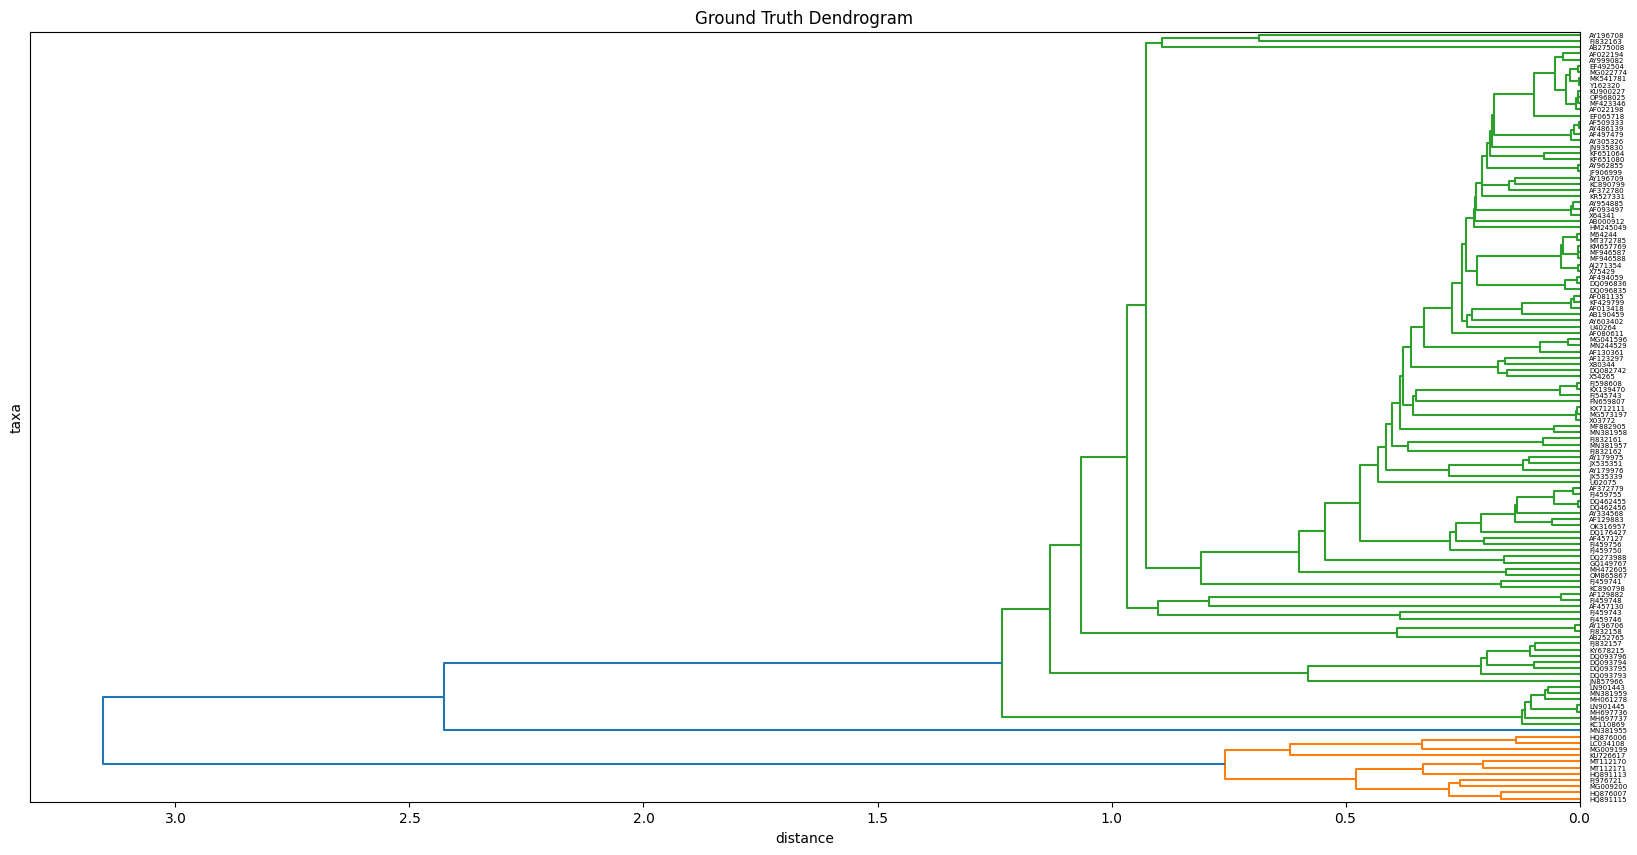

In [ ]:
#Plot the dendrogram
plt.figure(figsize=(20, 10))
greg_dendrogram = hierarchy.dendrogram(greg_linkage_matrix, labels=sequence_names, orientation='left')
plt.title('Ground Truth Dendrogram')
plt.xlabel('distance')
plt.ylabel('taxa')

plt.show()

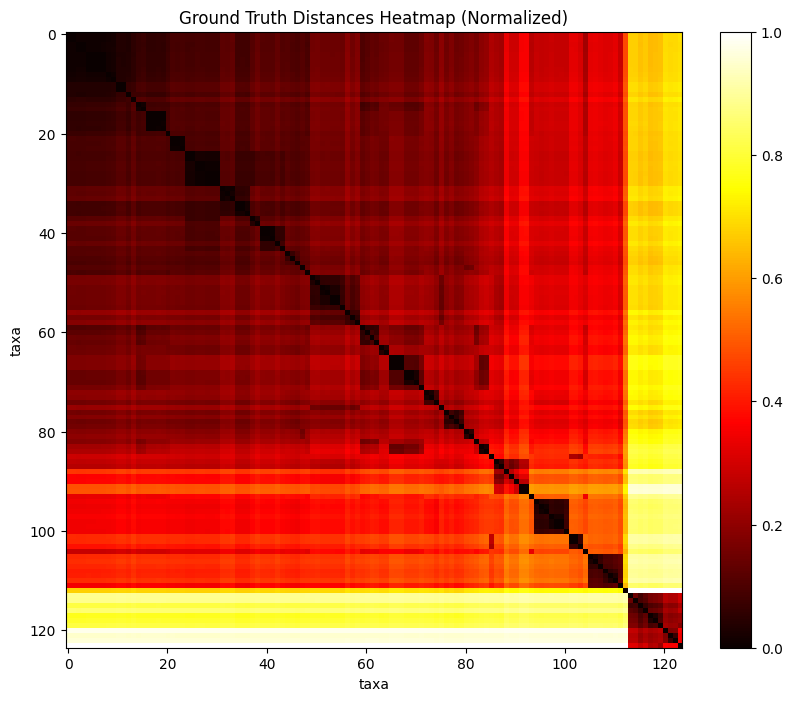

In [ ]:
# Create the heatmap
plt.figure(figsize=(10, 8))
heatmap = plt.imshow(greg_pd_norm, cmap='hot', interpolation='nearest')
plt.colorbar(heatmap)
plt.title('Ground Truth Distances Heatmap (Normalized)')
plt.xlabel('taxa')
plt.ylabel('taxa')
plt.show()

# COMPARE DISTANCE MATRICIES





In [ ]:
#Calcuate the pearson correlation values for respective taxa.

def pearson_correlation_list(matrix1, matrix2):
    # Calculate the means of matrix1 and matrix2
    mean_matrix1 = np.mean(matrix1)
    mean_matrix2 = np.mean(matrix2)

    # Calculate the differences from the means
    diff_matrix1 = matrix1 - mean_matrix1
    diff_matrix2 = matrix2 - mean_matrix2

    # Calculate the numerator and denominator of the correlation formula
    numerator = np.sum(diff_matrix1 * diff_matrix2)
    denominator = np.sqrt(np.sum(diff_matrix1 ** 2) * np.sum(diff_matrix2 ** 2))

    # Calculate the Pearson correlation coefficient
    correlation = numerator / denominator

    return correlation

In [ ]:
pearson_correlation_list(mlp_pd_norm, greg_pd_norm)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


AB000912   -0.206920
AB190459    0.218051
AB252765   -0.065503
AB275008   -0.215696
AF013418    0.099067
              ...   
X54265      0.439420
X64341      0.262050
X75429      0.426504
X80344      0.448176
Y162320     0.394389
Length: 124, dtype: float64

If you want to calculate the overall correlation value for the entire matrix, you can modify the code by flattening the matrices before calculating the correlation. Here's an updated version of the code that computes the overall correlation value:

In [ ]:
import numpy as np

def pearson_correlation_matrix(matrix1, matrix2):
    # Convert DataFrames to NumPy arrays
    array1 = matrix1.to_numpy().flatten()
    array2 = matrix2.to_numpy().flatten()

    # Calculate the means of the flattened arrays
    mean_array1 = np.mean(array1)
    mean_array2 = np.mean(array2)

    # Calculate the differences from the means
    diff_array1 = array1 - mean_array1
    diff_array2 = array2 - mean_array2

    # Calculate the numerator and denominator of the correlation formula
    numerator = np.sum(diff_array1 * diff_array2)
    denominator = np.sqrt(np.sum(diff_array1 ** 2) * np.sum(diff_array2 ** 2))

    # Calculate the Pearson correlation coefficient
    correlation = numerator / denominator

    return correlation

In [ ]:
pearson_correlation_matrix(mlp_pd_norm, greg_pd_norm)

0.6986454646844422